In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

In [2]:
import datajoint as dj
import pathlib
import itertools
import re
import tqdm

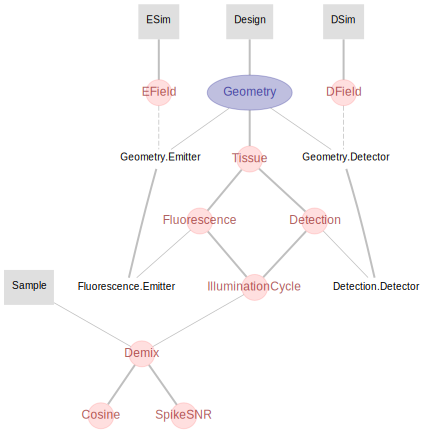

In [7]:
dj.Di(schema)

In [4]:
from neurophotonics.design import Design, Geometry

Connecting dbadmin@dimitri-proj0.cda95qzjbnvs.us-east-1.rds.amazonaws.com:3306


In [6]:
schema = dj.schema('photonics')
schema.spawn_missing_classes()

In [ ]:
dj.ERD(schema)

In [ ]:
ESim().delete()

In [ ]:
schema.jobs

In [ ]:
dj.config

In [ ]:
Sample()

In [ ]:
Geometry.populate(display_progress=True)

In [ ]:
set(zip(*(Geometry.Emitter & 'design=1').fetch('e_norm_x', 'e_norm_y', 'e_norm_z')))

# Design 1 Geometry

In [ ]:
r = {'design': 1}
fig, axx = plt.subplots(1, 2, figsize=(8,4))

ax = axx[0]

ax.set_aspect('equal')
ax.set_xlabel(r'$x\; (\mu\mathsf{m})$', fontsize=10)
ax.set_ylabel(r'$y\; (\mu\mathsf{m})$', fontsize=10)
ax.set_xticks(np.r_[-600:601:200])
ax.set_yticks(np.r_[-600:601:200])
ax.grid(True)

_ = (Geometry.Emitter & 'design=1').fetch('e_center_x', 'e_center_y', 'e_norm_x', 'e_norm_y')
for x, y, nx, ny in zip(*_):
    ax.plot((x, x+30*nx), (y, y+30*ny), 'g', alpha=0.2, lw=0.5)

_ = (Geometry.Detector & 'design=1').fetch('d_center_x', 'd_center_y', 'd_norm_x', 'd_norm_y')
for x, y, nx, ny in zip(*_):
    ax.plot((x, x+30*nx), (y, y+30*ny), 'k', alpha=0.2)


ax = axx[1]

ax.set_aspect('equal')
ax.set_xlabel(r'$y\; (\mu\mathsf{m})$', fontsize=10)
ax.set_ylabel(r'$z\; (\mu\mathsf{m})$', fontsize=10)
ax.grid(True)

_ = (Geometry.Emitter & 'design=1').fetch('e_center_x', 'e_center_z', 'e_norm_x', 'e_norm_z')
for x, z, nx, nz in zip(*_):
    ax.plot((x, x+30*nx), (z, z+30*nz), 'g', lw=0.5)

_ = (Geometry.Detector & 'design=1').fetch('d_center_y', 'd_center_z', 'd_norm_y', 'd_norm_z')
for y, z, ny, nz in zip(*_):
    ax.plot((y, y+30*ny), (z, z+30*nz), 'k', lw=1)

fig.suptitle('Design {design}'.format(**r))


fig.savefig('geometry-1.pdf')

# Designs 3 and 4 
The orientations of pixels (norms) were missing. 

25 shanks with 34 steerable emitters and 33 detectors

In [ ]:
r = {'design': 4}
fig, axx = plt.subplots(1, 2, figsize=(8,4))

ax = axx[0]

ax.set_aspect('equal')
ax.set_xlabel(r'$x\; (\mu\mathsf{m})$', fontsize=10)
ax.set_ylabel(r'$y\; (\mu\mathsf{m})$', fontsize=10)
ax.set_xticks(np.r_[-600:601:200])
ax.set_yticks(np.r_[-600:601:200])
ax.grid(True)

_ = (Geometry.Emitter & r).fetch('e_center_x', 'e_center_y', 'e_norm_x', 'e_norm_y')
for x, y, nx, ny in tqdm.tqdm(zip(*_)):
    ax.plot((x, x+30*nx), (y, y+30*ny), 'g-', alpha=0.2, lw=1)

_ = (Geometry.Detector & r).fetch('d_center_x', 'd_center_y', 'd_norm_x', 'd_norm_y')
_ = set(zip(*_))
for x, y, nx, ny in tqdm.tqdm(_):
    ax.plot((x, x+30*nx), (y, y+30*ny), 'k-', alpha=0.2)

ax = axx[1]

ax.set_aspect('equal')
ax.set_xlabel(r'$y\; (\mu\mathsf{m})$', fontsize=10)
ax.set_ylabel(r'$z\; (\mu\mathsf{m})$', fontsize=10)
ax.grid(True)

_ = (Geometry.Emitter & r).fetch('e_center_y', 'e_center_z', 'e_norm_y', 'e_norm_z')
_ = set(zip(*_))
for y, z, ny, nz in tqdm.tqdm(_):
    ax.plot((y, y+30*ny), (z, z+30*nz), 'g-', lw=1)

_ = (Geometry.Detector & r).fetch('d_center_y', 'd_center_z', 'd_norm_y', 'd_norm_z')
_ = set(zip(*_))
for y, z, ny, nz in tqdm.tqdm(_):
    ax.plot((y, y+30*ny), (z, z+30*nz), 'k-', lw=1)

fig.suptitle('Design {design}'.format(**r))

fig.savefig('geometry-4.png', dpi=300)

In [ ]:
set(zip(*(Geometry.Emitter & 'design=3').fetch('e_norm_x', 'e_norm_y', 'e_norm_z')))

In [ ]:
set(zip(*(Geometry.Detector & 'design=3').fetch('d_norm_x', 'd_norm_y', 'd_norm_z')))

In [ ]:
z = (Geometry.Detector & 'design=3').fetch('d_center_z')
plt.plot(np.cos((z - 5)*np.pi*9/40 + np.pi/16), np.sin((z - 5)*np.pi*9/40 + np.pi/16))
plt.axis('equal');

In [ ]:
!open geometry-4.pdf

In [ ]:
len(set(zip(*(Geometry.Emitter & r).fetch('e_center_x', 'e_center_y', 'e_center_z'))))

In [ ]:
len(set(zip(*(Geometry.Detector & r).fetch('d_center_x', 'd_center_y', 'd_center_z'))))

In [ ]:
825/25

In [ ]:
set(zip(*(Geometry.Detector & 'design=1').fetch('d_top_x', 'd_top_y', 'd_top_z')))

In [ ]:
set(zip(*(Geometry.Detector & 'design=1').fetch('d_norm_x', 'd_norm_y', 'd_norm_z')))

In [ ]:
a = np.array(sorted(list(set((Geometry.Emitter & 'design=3').fetch('e_center_z')))))

In [ ]:
np.diff(a)

In [ ]:
schema.spawn_missing_classes()
dj.Diagram(schema)

In [ ]:
Geometry.Detector()

In [ ]:
sorted(np.r_[:135*8:135] % 360)

In [ ]:
Geometry.Detector & 'design=1'

In [ ]:
Geometry.Detector

In [ ]:
dj.Diagram(schema)

In [ ]:
Geometry()

In [ ]:
DField * DSim

In [ ]:
Geometry.drop()

In [ ]:
dj.Diagram(schema)

In [ ]:
Design()

In [ ]:
np.r_[22.5:1080:135] % 360

In [ ]:
360*3

In [ ]:
min(np.array(sorted(list(set((Geometry.Emitter & 'design=4').fetch('e_center_z'))))))

In [ ]:
ls

In [ ]:
!open geometry-4.png